In [ ]:
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip

import os
!unzip 'rockpaperscissors.zip'

In [2]:

!pip install split-folders
import splitfolders
base_dir = 'rockpaperscissors/rps-cv-images'
splitfolders.ratio(base_dir, output=base_dir,seed=1337,ratio=(.6,0.4))
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')


Copying files: 2188 files [00:00, 3000.70 files/s]


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.3,0.1],
                    shear_range = 0.2,
                    fill_mode = 'nearest'
                    )

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [4]:
traingen= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
            batch_size=32,
    class_mode='sparse'
)
valgen=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse'
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [5]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [6]:
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.layers import Dropout

model=keras.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [7]:
base_model.trainable = False

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import Callback
class MyCallback(Callback):
  def on_epoch_end(self,epoch,logs=None):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.97):
      self.model.stop_training=True

In [20]:
callbacks = [MyCallback()]
model.fit(
      traingen,
      steps_per_epoch=traingen.samples // traingen.batch_size,
      validation_data=valgen,
      validation_steps=valgen.samples // valgen.batch_size,
      epochs=20,
      callbacks=callbacks)


Epoch 1/20
41/41 [==============================] - 15s 362ms/step - loss: 0.1561 - accuracy: 0.9505 - val_loss: 1.3894 - val_accuracy: 0.9618
Epoch 2/20
41/41 [==============================] - 14s 350ms/step - loss: 0.1380 - accuracy: 0.9581 - val_loss: 0.9302 - val_accuracy: 0.9722
Epoch 3/20
41/41 [==============================] - 14s 354ms/step - loss: 0.1280 - accuracy: 0.9665 - val_loss: 0.4093 - val_accuracy: 0.9826
Epoch 4/20
41/41 [==============================] - 14s 354ms/step - loss: 0.1222 - accuracy: 0.9611 - val_loss: 0.3248 - val_accuracy: 0.9873
Epoch 5/20
41/41 [==============================] - 14s 352ms/step - loss: 0.1175 - accuracy: 0.9657 - val_loss: 0.6877 - val_accuracy: 0.9838
Epoch 6/20
41/41 [==============================] - 15s 358ms/step - loss: 0.1621 - accuracy: 0.9527 - val_loss: 0.7027 - val_accuracy: 0.9792
Epoch 7/20
41/41 [==============================] - 15s 356ms/step - loss: 0.1264 - accuracy: 0.9642 - val_loss: 0.4635 - val_accuracy: 0.9826

In [21]:
base_model.trainable = True
fine_tune_at = 15  # Fine-tuning dari lapisan ke-15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    traingen,
    steps_per_epoch=traingen.samples // traingen.batch_size,
    validation_data=valgen,
    validation_steps=valgen.samples // valgen.batch_size,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
41/41 [==============================] - 17s 351ms/step - loss: 0.1910 - accuracy: 0.9573 - val_loss: 0.2638 - val_accuracy: 0.9919
Epoch 2/10
41/41 [==============================] - 14s 353ms/step - loss: 0.1385 - accuracy: 0.9649 - val_loss: 0.1337 - val_accuracy: 0.9907
Epoch 3/10
41/41 [==============================] - 14s 353ms/step - loss: 0.1697 - accuracy: 0.9482 - val_loss: 0.0890 - val_accuracy: 0.9931
Epoch 4/10
41/41 [==============================] - 15s 356ms/step - loss: 0.1267 - accuracy: 0.9710 - val_loss: 0.0506 - val_accuracy: 0.9965


Saving batu.jpg to batu.jpg
1/1 [==============================] - 0s 28ms/step
gambar tersebut merupakan batu.jpg: rock


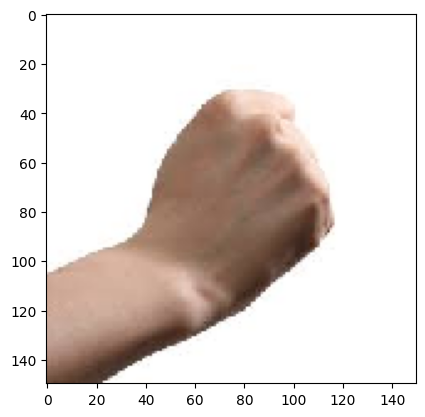

In [25]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  img = image.load_img(path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  prediction = model.predict(img_tensor)
  classes = ['paper', 'rock', 'scissors']
  predicted_class = classes[np.argmax(prediction[0])]
  print(f'gambar tersebut merupakan {fn}: {predicted_class}')

Nama : Zahid Faqih Alim Rabbani
Alamat : Jakarta Timur